# Binary Precipitation

## Example - The Al-Zr system

In the Al-Zr system, $Al_3Zr$ can precipitate into an $\alpha$-Al (FCC) matrix. The Thermodynamics module provides some functions to interface with pyCalphad in defining the driving force and interfacial composition. However, it is also possible to use user-defined functions for the driving force and nucleation as long as the function parameters and return values are consistent with the ones provides by the Thermodynamics module. Calphad models for the Al-Zr system was obtained from the STGE database and Wang et al [1,2].

For a binary system, one hyperparameter that may need to be set in the Thermodynamics module for calculating interfacial compositions is the guess composition when finding a tie-line. The $Al_3Zr$ phase has a fixed composition at 25 at.% Zr, so the guess composition can be set to 24 at.% Zr.

In [1]:
from kawin.Thermodynamics import BinaryThermodynamics
from kawin.KWNEuler import PrecipitateModel
import numpy as np

therm = BinaryThermodynamics('AlZr.tdb', ['AL', 'ZR'], ['FCC_A1', 'AL3ZR'])
therm.setGuessComposition(0.24)

## Setting up the model

Inititializing the KWN model will require the initial and final time, the number of time steps, the bounds for the particle size distribution (PSD) and the number of bins for the PSD.

The Al-Zr system will be ran at $450\text{ }^oC$ for 500 hours. 25,000 steps will be used. Adaptive time stepping is on by default; however, it tends to work well if if the model is initialized with at least 5,000 - 10,000 steps. The PSD will be composed of 100 bins ranging from 0.1 to 10nm. Bins will be added automatically to the PSD during the simulation to account for particles growing larger than the initial range.

The time can be either on a linear or a logarithmic scale.

In [2]:
#Initial and final time in seconds
t0 = 0
tf = 500*3600
steps = 2.5e4

#Create model
model = PrecipitateModel(t0, tf, steps, linearTimeSpacing = True)

## Model Inputs

The interfacial energy and diffusivity are from Robson and Prangnell [3]. Although the diffusivity for this system is only a function of temperature, it needs to be defined as a function of both composition and temperature (to keep consistent with systems that use composition dependent diffusivity).

$ x_0 = 0.4 \: \text{at.\%} $

$ T = 450 \: ^oC = 723.15 \: K $

$ \gamma = 0.1 \: J/m^2 $

$ D = 0.0768 \, exp\left(- \frac{242000}{R T}\right) \: m^2/s $

$ a = 0.405 \: nm = 0.405\mathrm{e}{-9} \: m $

4 atoms per unit cell

Dislocation density $ \rho_D = 1e15 $


In [3]:
xInit = 4e-3        #Initial composition (mole fraction)
model.setInitialComposition(xInit)

T = 450 + 273.15    #Temperature (K)
model.setTemperature(T)

gamma = 0.1         #Interfacial energy (J/m2)
model.setInterfacialEnergy(gamma)

D0 = 0.0768         #Diffusivity pre-factor (m2/s)
Q = 242000          #Activation energy (J/mol)
Diff = lambda x, T: D0 * np.exp(-Q / (8.314 * T))
model.setDiffusivity(Diff)

a = 0.405e-9        #Lattice parameter
Va = a**3           #Atomic volume of FCC-Al
Vb = a**3           #Assume Al3Zr has same unit volume as FCC-Al
atomsPerCell = 4    #Atoms in an FCC unit cell
model.setVaAlpha(Va, atomsPerCell)
model.setVaBeta(Vb, atomsPerCell)

#Average grain size (um) and dislocation density (1e15)
model.setNucleationDensity(grainSize = 1, dislocationDensity = 1e15)
model.setNucleationSite('dislocations')

#Set thermodynamic functions
model.setThermodynamics(therm)

## Solving the Model

Now we can run the model. The current status of the model may be output by setting "verbose" to True with "vIt" being how many iterations will pass before the current status of the model is printed out.

In [4]:
model.solve(verbose=True, vIt=10000)

N	Time (s)	Temperature (K)	Matrix Comp
10000	6.9e+05		723		0.0138

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	3.924e+22	1.5457		4.3538e-09

N	Time (s)	Temperature (K)	Matrix Comp
20000	1.4e+06		723		0.0130

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	2.119e+22	1.5487		5.3297e-09

Finished in 76.914 seconds.


## Plotting

We can now plot the results. Here, we are plotting the precipitate density, volume fraction and average radius as a function of time and the size distribution density at the final time.

Everything will be plotted on a logarithmic time scale.


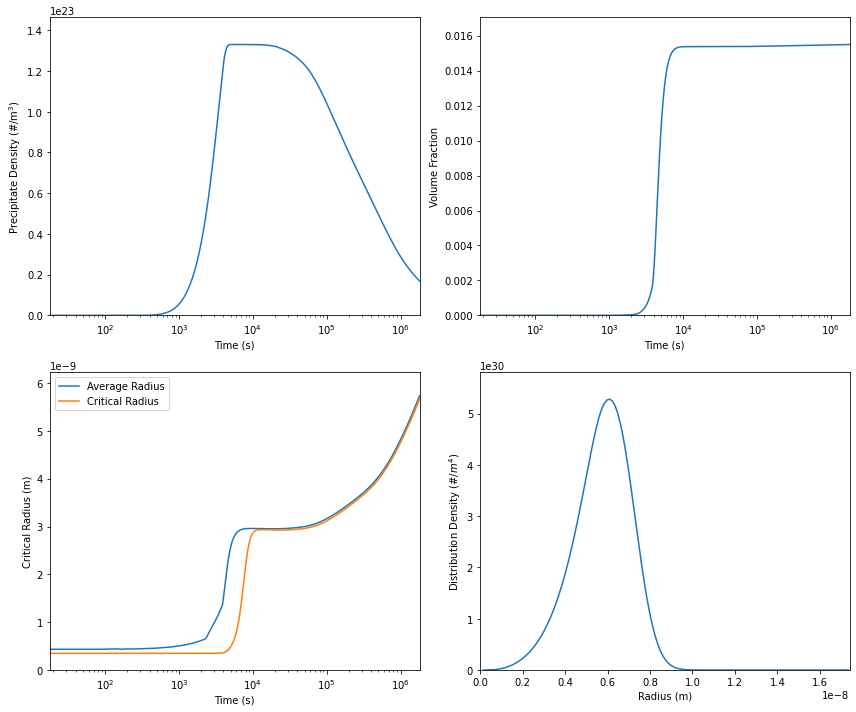

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

model.plot(axes[0,0], 'Precipitate Density')
model.plot(axes[0,1], 'Volume Fraction')
model.plot(axes[1,0], 'Average Radius', label='Average Radius')
model.plot(axes[1,0], 'Critical Radius', label='Critical Radius')
axes[1,0].legend()
model.plot(axes[1,1], 'Size Distribution Density')

fig.tight_layout()

## Saving

The model can be saved into a numpy .npz format or a .csv format.

$ PrecipitateModel.save(filename, compressed=True) $ or 

$ PrecipitateModel.save(filename, toCSV=True) $

<br>

To load the model, just make sure to add the file extension.

$ model = PrecipitateModel.load('file.npz') $ or

$ model = PrecipitateModel.load('file.csv') $

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* 15 (1991) p. 317
2. T. Wang, Z. Jin and J. Zhao, “Thermodynamic Assessment of the Al-Zr Binary System” *Journal of Phase Equilibria* 22 (2001) p. 544
3. J. D. Robson and P. B. Prangnell, “Dispersoid Precipitation and Process Modeling in Zirconium Containing Commercial Aluminum Alloys” *Acta Materialia* 49 (2001) p. 599